In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '64'

In [2]:
import jax
import jax_cosmo as jc
import jax.numpy as np

In [3]:
cosmo = jc.Planck15()

In [4]:
kk = np.geomspace(1e-4,10,1000)
pk = jc.power.linear_matter_power(cosmo, kk)

/global/homes/x/xuod/.conda/envs/myenv3/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


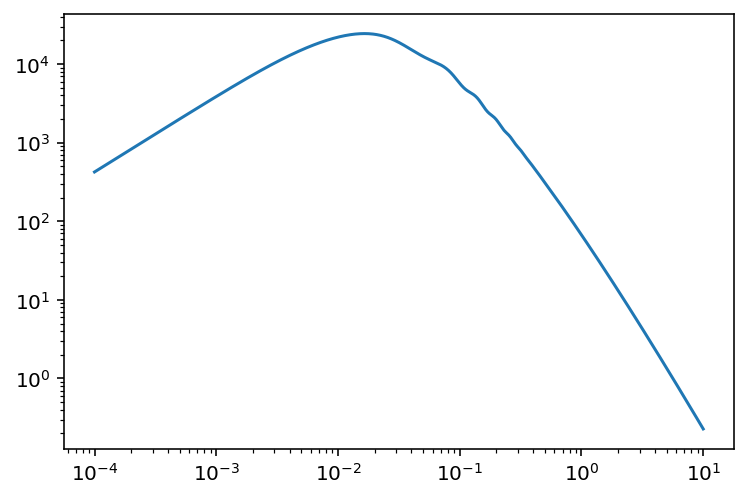

In [5]:
plt.loglog(kk, pk)

In [6]:
nzs = [jc.redshift.smail_nz(1., 2., z0) for z0 in [0.5, 1., 1.5]]

In [7]:
wls = jc.probes.WeakLensing(nzs, sigma_e=0.26)

In [8]:
ell = np.geomspace(10, 2000, 32)

In [9]:
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [wls], sparse=False);

/global/homes/x/xuod/.conda/envs/myenv3/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


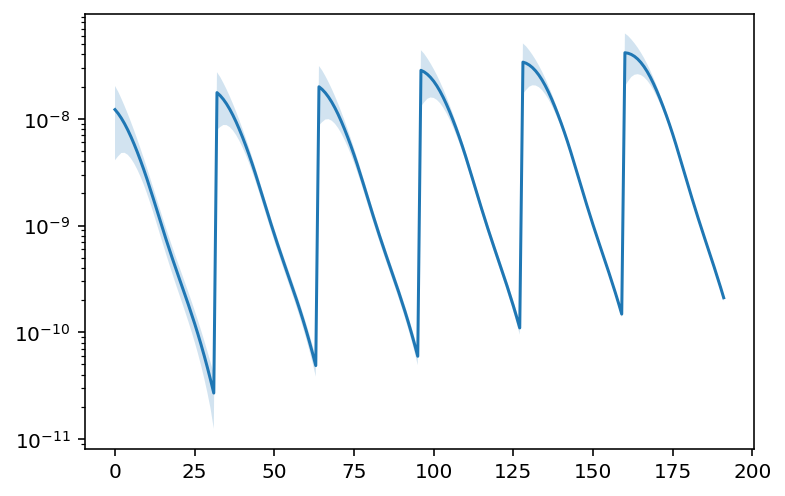

In [10]:
plt.semilogy(mu)
s = np.sqrt(np.diagonal(np.stack(cov)))
plt.fill_between(range(len(mu)), mu-s, mu+s, alpha=0.2)

In [11]:
data = mu # We create some fake data from the fiducial cosmology
# Let's define a parameter vector for Omega_cdm, sigma8, which we initialize 
# at the fiducial cosmology used to produce the data vector.
params = np.array([cosmo.Omega_c, cosmo.sigma8]) 

# Note the `jit` decorator for just in time compilation, this makes your code
# run fast on GPU :-)
@jax.jit
def likelihood(p):
    # Create a new cosmology at these parameters
    cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])

    # Compute mean and covariance of angular Cls
    m, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [wls], sparse=True)

    # Return likelihood value assuming constant covariance, so we stop the gradient
    # at the level of the precision matrix, and we will not include the logdet term
    # in the likelihood
    P = jc.sparse.inv(jax.lax.stop_gradient(C))
    r = data - m
    return -0.5 * r.T @ jc.sparse.sparse_dot_vec(P, r)

d_likelihood = jax.grad(likelihood)

In [12]:
from flowMC.nfmodel.realNVP import RealNVP
from flowMC.sampler.MALA import mala_sampler
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys
from flowMC.nfmodel.utils import *

In [13]:
### Demo config

n_dim = len(params)
n_chains = 10
n_loop = 5
n_local_steps = 100
n_global_steps = 100
learning_rate = 0.1
momentum = 0.9
num_epochs = 5
batch_size = 50
stepsize = 0.01

print("Preparing RNG keys")
rng_key_set = initialize_rng_keys(n_chains, seed=42)

print("Initializing MCMC model and normalizing flow model.")
initial_position = jax.random.normal(rng_key_set[0], shape=(n_chains, n_dim)) * 1

model = RealNVP(10, n_dim, 64, 1)
run_mcmc = jax.vmap(mala_sampler, in_axes=(0, None, None, None, 0, None), out_axes=0)

Preparing RNG keys
Initializing MCMC model and normalizing flow model.


In [14]:
print("Initializing sampler class")
nf_sampler = Sampler(n_dim, rng_key_set, model, run_mcmc,
                    likelihood,
                    d_likelihood=d_likelihood,
                    # n_loop=n_loop,
                    # n_local_steps=n_local_steps,
                    # n_global_steps=n_global_steps,
                    # n_chains=n_chains,
                    # n_epochs=num_epochs,
                    # n_nf_samples=100,
                    # learning_rate=learning_rate,
                    # momentum=momentum,
                    # batch_size=batch_size,
                    # stepsize=stepsize,
                    # use_global=True,
                    )

Initializing sampler class


In [ ]:
print("Sampling")
nf_sampler.sample(initial_position)

Sampling


/global/homes/x/xuod/.conda/envs/myenv3/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


In [ ]:
chains, log_prob, local_accs, global_accs, loss_vals = nf_sampler.get_sampler_state()
nf_samples = nf_sampler.sample_flow()

print(
    "chains shape: ",
    chains.shape,
    "local_accs shape: ",
    local_accs.shape,
    "global_accs shape: ",
    global_accs.shape,
)

chains = jnp.array(chains)
nf_samples = jnp.array(nf_samples[1])
loss_vals = jnp.array(loss_vals)